## Bootstrapping the harmonic mean

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1bv2w06/q_can_you_calculate_a_standard_error_for_harmonic).

> Can you calculate a standard error for harmonic mean?
>
> I’m trying to use harmonic mean instead of arithmetic because it might describe my data better (there are a few extreme outliers). My question is, I’ve read that you can’t calculate a standard deviation for the harmonic mean, so does that mean I can’t calculate a standard error then? That feels wrong.

The immediate question is how to compute the standard error of a harmonic mean.
But there are two more questions here that I think are worth addressing:

* Is the harmonic mean a good choice for summarizing this dataset?

* Is it true that "You can’t calculate a standard deviation for the harmonic mean"?

Let's answer the immediate question first, using bootstrap resampling.
If you are not familiar with bootstrapping, there's an introduction in Chapter 12 of [*Elements of Data Science*](https://allendowney.github.io/ElementsOfDataScience/12_bootstrap.html).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/harmonic.ipynb)

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

## Generating a dataset

To demonstrate the behavior of the harmonic mean, I'll generate two datasets, one from a Gaussian, and another with the same data plus a few outliers.

The first dataset contains `n=100` values from a Gaussian distribution with mean 10 and standard deviation 1.

In [2]:
mu = 10
sigma = 1

np.random.seed(1)
data = np.random.normal(10, 1, size=100)

The (arithmetic) mean is close to 10, as expected.

In [3]:
np.mean(data)

10.060582852075699

And the harmonic mean is not much different.

In [4]:
from scipy.stats import hmean

hmean(data)

9.981387932002434

OP says the dataset contains "a few extreme outliers".
Without context, it's hard to day how extreme they are.
But in a Gaussian distribution, values 4-6 standard deviations from the mean might be considered extreme.
So I'll add in one of each.

In [5]:
data2 = np.concatenate([data, [14, 15, 16]])

Here's what the distribution of the data looks like with the outliers.

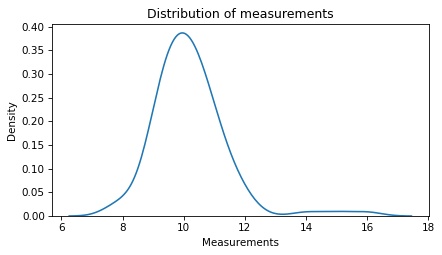

In [6]:
sns.kdeplot(data2)
decorate(xlabel='Measurements',
         ylabel='Density',
         title='Distribution of measurements')

The outliers increase the mean of the data substantially.

In [7]:
np.mean(data2)

10.20444937094728

They have a smaller effect on the harmonic mean -- which seems like it's the primary reason OP is using it.

In [8]:
hmean(data2)

10.079025419217924

## Bootstrapping

Now let's compute the standard error of the harmonic mean using bootstrap resampling.
The following function takes a dataset as a parameter, draws a random sample from it with replacement, and returns the harmonic mean of the resampled data.

In [9]:
def bootstrap_hmean(data):
    resampled = np.random.choice(data, size=len(data), replace=True)
    return hmean(resampled)

If we call this function 1000 times, we get a sample from from sampling distribution of the harmonic mean.

In [10]:
sample = [bootstrap_hmean(data2) for i in range(1000)]

Here's what the sampling distribution looks like.

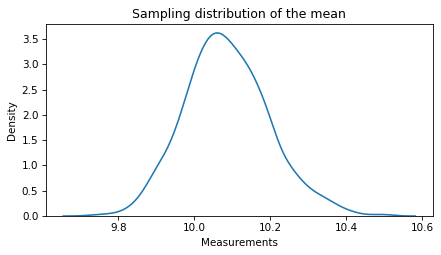

In [11]:
sns.kdeplot(sample)
decorate(xlabel='Measurements',
         ylabel='Density',
         title='Sampling distribution of the mean')

The standard deviation of these values is an estimate of the standard error.

In [12]:
se = np.std(sample)
se

0.11120255874179302

As an alternative to the standard error, we can estimate the 90% confidence interval by computing the 5th and 95th percentiles of the sample.

In [13]:
ci90 = np.percentile(sample, [5, 95])
ci90

array([ 9.90600311, 10.27715017])

So that's the answer to the immediate question -- there's nothing unusually difficult about computing the standard error of a harmonic mean.

Now let's get to the other questions.
First, what did OP mean by "I’ve read that you can’t calculate a standard deviation for the harmonic mean"?
I'm not sure, but one possibility is that they read something else: that there is no mathematical formula for the standard error of the harmonic mean, as there is for the arithmetic mean.
That's true, which is why bootstrapping is particularly useful.

## Why harmonic?

The other outstanding question is whether the harmonic mean is the best choice for summarizing this data.
Without more context, I can't say, but I can offer some general advice.

The harmonic mean is often a good choice when the quantities in the dataset are rates.
As an example, suppose you drive to the store at 20 mph and then return on the same route at 30 mph.
If you want to know your average speed for the round trip, you might be tempted to compute the arithmetic mean.

In [14]:
np.mean([20, 30])

25.0

But that's not right.
To see why, suppose the store is 60 miles away, so it takes 3 hours on the way there and 2 hours on the way back.
That's 120 miles in 5 hours, which is 24 mph on average.
The harmonic mean is the equivalent of this calculation, and produces the same answer (within floating-point error).

In [15]:
hmean([20, 30])

23.999999999999996

So that's a case where the harmonic mean naturally computes the quantity we're interested in. More generally, the harmonic mean *might* be a good choice when the quantities are rates or ratios, but in my opinion this advice is often stated too strongly.
It depends on the context, and on what question you are trying to answer.

For example, suppose you drive at 20 mph for an hour, and then 30 mph for an hour, and you want to know your average speed for the whole trip.
In this case, the arithmetic mean is correct -- you traveled 50 miles in 2 hours, so the average is 25 mph.

If OP is using the harmonic mean only because the dataset has a few outliers, it might not be the best choice.
The harmonic mean is relatively robust to outliers if they are above the mean, but it is relatively sensitive to outliers below the mean.

As an example, here's another dataset with outliers 4-6 standard deviations below the mean.

In [16]:
data3 = np.concatenate([data, [6, 5, 4]])

As expected, the arithmetic mean gets dragged down by these outliers.

In [17]:
np.mean(data3)

9.913187235024951

But the harmonic mean gets dragged down even more!

In [18]:
hmean(data3)

9.684716917792475

So outliers alone are not a strong reason to use the harmonic mean.

If there is reason to think the outliers are genuine errors, like bad measurements, the best choice might be a trimmed mean.
In this example, trimming 10% of the data works well for all the datasets: the one with no outliers, outliers above the mean, and outliers below the mean.

In [19]:
from scipy.stats import trim_mean

trim_mean(data, proportiontocut=0.1)

10.054689104329984

In [20]:
trim_mean(data2, proportiontocut=0.1)

10.099867738778054

In [21]:
trim_mean(data3, proportiontocut=0.1)

10.01327288288814

In all three cases, the estimated mean is close to the actual mean of the dataset, before the addition of outliers. 